# 2021/10/7
# 本代码绘制不同指标的孟加拉湾地区的时间序列
# 风向，温度差，高低层风的差

In [1]:
import xarray as xr
import numpy as np
import os
import math
import sys
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *

np.set_printoptions(suppress=True)

In [2]:
def cal_jan_angle(u,v):
    u_jan      =  np.average(u[0:31,:],axis=0)
    v_jan      =  np.average(v[0:31,:],axis=0)
    angle_jan  =  u_jan.copy()
    for i in range(0,u_jan.shape[0]):
        for j in range(0,u_jan.shape[1]):
            if (u_jan[i,j]==0 and v_jan[i,j]<0):
                angle_jan[i,j] = 0 ; continue
            elif (u_jan[i,j]==0 and v_jan[i,j]>0):
                angle_jan[i,j] = 180 ; continue
                
            if u_jan[i,j] >0:
                angle_jan[i,j]  =  270 - math.degrees(np.arctan(v_jan[i,j]/u_jan[i,j]))
            else:
                angle_jan[i,j]  =  90  - math.degrees(np.arctan(v_jan[i,j]/u_jan[i,j]))

    return angle_jan

def cal_angle(u,v):
    angle  =  u.copy()
    for i in range(0,u.shape[0]):
        for j in range(0,u.shape[1]):
            if (u[i,j]==0 and v[i,j]<0):
                angle[i,j] = 0 ; continue
            elif (u[i,j]==0 and v[i,j]>0):
                angle[i,j] = 180 ; continue
                
            if u[i,j] >0:
                angle[i,j]  =  270 - math.degrees(np.arctan(v[i,j]/u[i,j]))
            else:
                angle[i,j]  =  90  - math.degrees(np.arctan(v[i,j]/u[i,j]))

    return angle


In [10]:
path  =  "/home/sun/qomo-data/zhuang_plev/"
lat_slice   =   slice(0,30)
lon_slice   =   slice(90,100)
lev_slice1  =   [1000,975,925,850,200]
lev_slice2  =   slice(500,200)
lev_slice3  =   [850,200]

f0    =   xr.open_dataset(path+"plev_con_T.nc")
#计算风向差
u850  =   xr.open_dataset(path+"plev_con_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)
u200  =   xr.open_dataset(path+"plev_con_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=200)
u_delta     =  u850-u200  #东风切变
u_delta_avg =  np.average(np.average(u_delta.U,axis=1),axis=1)

#计算上层经向温度梯度
upper_t      =  xr.open_dataset(path+"plev_con_T.nc").sel(lat=lat_slice,lon=lon_slice,lev=lev_slice2)
upper_t_2    =  np.average(np.average(upper_t.T,axis=1),axis=2)
upper_t_diff =  upper_t_2[:,10] - upper_t_2[:,0]

#计算风向角 使用975、950、925的uv风场都整一波
levs  =  [1000,975,950,925]
import math
u     =  xr.open_dataset(path+"plev_con_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)
v     =  xr.open_dataset(path+"plev_con_V.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)


angle_jan  =  cal_jan_angle(u.U.data,v.V.data)
#这里计算风向角计算全年的吧
angle      =  u.U.data.copy()
for d in range(0,angle.shape[0]):
    angle[d,:]  =  cal_angle(u.U.data[d,:],v.V.data[d,:])
#计算侯平均
angle_pen  =  np.zeros((73,angle.shape[1],angle.shape[2]))
angle_diff =  angle_pen.copy()
for p in range(0,73):
    angle_pen[p,:]  =  np.average(angle[p*5:(p*5+5),:],axis=0)
    angle_diff[p,:] =  angle_pen[p,:] - angle_jan

angle_mask   = angle_diff.copy()
for i in range(0,angle_mask.shape[0]):
    for j in range(0,angle_mask.shape[1]):
        for z in range(0,angle_mask.shape[2]):
            if angle_mask[i,j,z] > 180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]-360)
            if angle_diff[i,j,z] < -180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]+360)
    

angle_diff_avg_lat  =  np.average(angle_diff,axis=2)





# 处理erain表面风数据

In [17]:
#u_era  =  xr.open_dataset("/home/sun/data/pentad_average/era5_u10_pentad_climate.nc").sel(lat=lat_slice,lon=lon_slice)
#v_era  =  xr.open_dataset("/home/sun/data/pentad_average/era5_v10_pentad_climate.nc").sel(lat=lat_slice,lon=lon_slice)
wind_era  =  xr.open_dataset("/home/sun/data/merra2_u2v2_climate.nc").sel(lat=lat_slice,lon=(95,100))
u_pentad  =  np.zeros((73,wind_era.u2_climate.data.shape[1],wind_era.u2_climate.data.shape[2]))
v_pentad  =  u_pentad.copy()
for p in range(0,73):
    u_pentad[p,:]  =  np.average(wind_era.u2_climate.data[p*5:p*5+5,:],axis=0)
    v_pentad[p,:]  =  np.average(wind_era.v2_climate.data[p*5:p*5+5,:],axis=0)

#计算1月平均
u_era_jan  =  np.average(wind_era.u2_climate.data[0:30,:],axis=0)
v_era_jan  =  np.average(wind_era.v2_climate.data[0:30,:],axis=0)

angle_era_jan  =  u_era_jan.copy()

for i in range(0,u_era_jan.shape[0]):
    for j in range(0,u_era_jan.shape[1]):
        if (u_era_jan[i,j]==0 and v_era_jan[i,j]<0):
            angle_era_jan[i,j] = 0 ; continue
        elif (u_era_jan[i,j]==0 and v_era_jan[i,j]>0):
            angle_era_jan[i,j] = 180 ; continue
            
        if u_era_jan[i,j] >0:
            angle_era_jan[i,j]  =  270 - math.degrees(np.arctan(v_era_jan[i,j]/u_era_jan[i,j]))
        else:
            angle_era_jan[i,j]  =  90  - math.degrees(np.arctan(v_era_jan[i,j]/u_era_jan[i,j]))

angle_era      =  u_pentad.copy()
angle_era_diff =  angle_era.copy()
for d in range(0,angle_era.shape[0]):
    angle_era[d,:]  =  cal_angle(u_pentad[d,:],v_pentad[d,:])
    angle_era_diff[d,:] =  angle_era[d,:] - angle_era_jan

angle_era_mask   = angle_era_diff.copy()
for i in range(0,angle_era_mask.shape[0]):
    for j in range(0,angle_era_mask.shape[1]):
        for z in range(0,angle_era_mask.shape[2]):
            if angle_era_mask[i,j,z] > 180:
                angle_era_diff[i,j,z]  =  abs(angle_era_diff[i,j,z]-360)
            if angle_era_diff[i,j,z] < -180:
                angle_era_diff[i,j,z]  =  abs(angle_era_diff[i,j,z]+360)

angle_era_diff_avg_lat  =  np.average(angle_era_diff,axis=2)

/tmp/ipykernel_689927/1374641581.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(h,orientation='horizontal', pad=0.11, aspect=90,extend='both',extendfrac='auto',)
/tmp/ipykernel_689927/1374641581.py:12: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(h,orientation='horizontal', pad=0.11, aspect=90,extend='both',extendfrac='auto',)
/tmp/ipykernel_689927/1374641581.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['EQ',u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N', u'15\N{DEGREE SIGN}N',


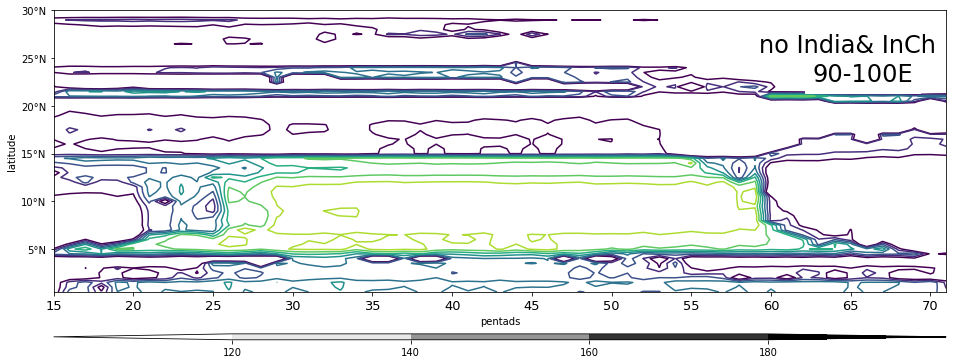

In [20]:
#绘制风向角转变的时间-纬度图
import matplotlib.pyplot as plt
import matplotlib
fig1, axes = plt.subplots(figsize = (16,7))
props = dict(boxstyle='square', facecolor='white', edgecolor='white',alpha=1)

levels = np.arange(20, 200,20)
#levels = np.arange(140, 240,20)

#h = axes.contourf(np.linspace(1,73,73),u.lat.data,np.transpose(angle_diff_avg_lat,(1,0)), levels = levels,cmap='Greys',extend='both')
axes.contour(np.linspace(1,73,73),wind_era.lat.data,np.transpose(angle_era_diff_avg_lat,(1,0)), levels = levels)
cbar = plt.colorbar(h,orientation='horizontal', pad=0.11, aspect=90,extend='both',extendfrac='auto',)


axes.set_xticks(np.linspace(9, 69, 13))
axes.set_xticklabels(range(10, 75, 5),fontsize=13)
axes.set_xlim([14, 70])
axes.set_yticklabels(['EQ',u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N', u'15\N{DEGREE SIGN}N',
                        u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N'])
axes.text(0.79,0.85,"no India& InCh",transform=axes.transAxes,bbox=props,fontsize=24)
axes.text(0.85,0.75,"90-100E",transform=axes.transAxes,bbox=props,fontsize=24)
axes.set_xlabel('pentads')
axes.set_ylabel('latitude')

plt.savefig('/home/sun/paint/wind_angle_convert/angle_convert_icid.pdf', bbox_inches='tight',dpi=1200)
plt.show()

In [6]:
np.transpose(angle_diff_avg_lat,(1,0)).shape

(32, 73)

In [7]:
angle_diff_avg_lat.shape

(73, 32)